In [1]:
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))

import configparser
import logging
from functools import partial
from typing import OrderedDict

import numpy as np
from shapely import Polygon

from bbtoolkit.dynamics import DynamicsManager
from bbtoolkit.dynamics.callbacks.attention import AttentionCallback
from bbtoolkit.dynamics.callbacks.fov import EgoCallback, EgoSegmentationCallback, FOVCallback, ParietalWindowCallback
from bbtoolkit.dynamics.callbacks.movement import MovementCallback, MovementSchedulerCallback, TrajectoryCallback
from bbtoolkit.dynamics.callbacks.viz import AgentPlotter, PlottingCallback

from bbtoolkit.models.bb.callbacks import FramesStoringCallback, TimerCallback
from bbtoolkit.models.bb.callbacks.memory import ObjectWeightsUpdatingCallback
from bbtoolkit.models.bb.callbacks.movement import MentalMovementCallback, MentalMovementSchedulerCallback, MentalPositionCallback, MentalTrajectoryCallback
from bbtoolkit.models.bb.callbacks.populations import BVCCallback, GCRateCallback, HDCallback, IPRateCallback, OVCCallback, PCCallback, PRCallback, PWCallback,\
    TCCallback, oPRCallback, oPWCallback, oTCCallback
from bbtoolkit.models.bb.callbacks.viz import AloEnvPlotter, BVCPlotter, DistanceAttentionPlotter, EgoEnvPlotter, HDPlotter, MentalAgentPlotter,\
    MentalTargetPlotter, MentalTrajectoryPlotter, MouseEventCallback, OVCPlotter, ObjectRecallCallback, PCPlotter, PWPlotter, PickedObjectPlotter,\
    TargetPlotter, TimerPlotter, TrajectoryPlotter, oPRPlotter, oPWPlotter
from bbtoolkit.models.bb.structures import BBCache, ClickParameters, DynamicParameters, EcodingParameters
from bbtoolkit.models.bb.utils import Grid2CartTransition, connectivity_config2dict, activity2rate
from bbtoolkit.models.bb.neural_generators import TCGenerator, GCMap

from bbtoolkit.utils.attention import DistanceAttention
from bbtoolkit.utils.movement import MovementManager
from bbtoolkit.utils.movement.trajectory import AStarTrajectory
from bbtoolkit.utils.datautils import Cached
from bbtoolkit.utils.datautils.configparser import EvalConfigParser
from bbtoolkit.utils.math import pol2cart
from bbtoolkit.utils.math.geometry import calculate_polar_distance, points2segments
from bbtoolkit.utils.viz.colors import generate_cmap

from bbtoolkit.environment import Environment
from bbtoolkit.environment.compilers import DynamicEnvironmentCompiler
from bbtoolkit.environment.compilers.callbacks import TransparentObjects
from bbtoolkit.environment.utils import env2builder
from bbtoolkit.environment.visible_planes import LazyVisiblePlaneWithTransparancy
from bbtoolkit.environment.fov import FOVManager
from bbtoolkit.environment.fov.ego import EgoManager

from bbtoolkit.structures.geometry import Texture, TexturedPolygon
from bbtoolkit.structures.tensorgroups import DirectedTensorGroup, dict2directed_tensor, DirectedTensor, TensorGroup, NamedTensor


In [2]:
from bbtoolkit.models.bb.neural_generators import MTLGenerator


env = environment = Environment.load('../data/envs/square_environment.pkl')
mtl_cfg = '../cfg/cells/mtl_cells.ini'
config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
config.read(mtl_cfg)

space_section = config['Space']
res = space_section.eval('res')
r_max = space_section.eval('r_max')

polargrid_section = config['PolarGrid']
polar_dist_res = polargrid_section.eval('polar_dist_res')
polar_ang_res = polargrid_section.eval('polar_ang_res', locals=dict(pi=np.pi))
h_sig = polargrid_section.eval('sigma_hill')


gen = MTLGenerator(
    r_max, h_sig, polar_dist_res, polar_ang_res, env
)

coords, n_h_neurons_total, n_neurons = gen.get_coords()
n_bvc, bvc_dist, bvc_ang = gen.get_bvc_params()

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from collections import namedtuple

# Assuming Sample is defined as:
Sample = namedtuple('Sample', 'coords bvc pc')



In [4]:
from bbtoolkit.models.bb.neural_generators import get_boundary_activations
from bbtoolkit.structures.geometry import Coordinates2D


samples = list()

for location in range(environment.walls[0].visible_parts.shape[0]):
    pos_x = environment.params.coords[location, 0]
    pos_y = environment.params.coords[location, 1]
    all_visible_parts_x, all_visible_parts_y, all_non_nan_indices, all_boundary_point_texture = list(), list(), list(), list()
    for wall in environment.walls:
        visible_parts_x = wall.visible_parts[location, :, 0]
        visible_parts_y = wall.visible_parts[location, :, 1]
        non_nan_indices = np.where(~np.isnan(visible_parts_x))[0]
        boundary_point_texture = wall.polygon.texture.id_*np.ones_like(non_nan_indices)
        all_visible_parts_x.append(visible_parts_x[non_nan_indices])
        all_visible_parts_y.append(visible_parts_y[non_nan_indices])
        all_non_nan_indices.append(non_nan_indices)
        all_boundary_point_texture.append(boundary_point_texture)

    visible_parts_x = np.concatenate(all_visible_parts_x)
    visible_parts_y = np.concatenate(all_visible_parts_y)
    visible_boundary_points = Coordinates2D(
        visible_parts_x - pos_x,
        visible_parts_y - pos_y
    )
    non_nan_indices = np.concatenate(all_non_nan_indices)
    boundary_point_texture = np.concatenate(all_boundary_point_texture)

    boundary_theta, boundary_r = np.arctan2(visible_boundary_points.y, visible_boundary_points.x), np.sqrt(visible_boundary_points.x**2 + visible_boundary_points.y**2)
    boundary_r[boundary_r < gen.polar_dist_res] = gen.polar_dist_res

    h_activarions = np.exp(-((coords.x.reshape((-1, 1)) - pos_x)**2 + (coords.y.reshape((-1, 1)) - pos_y)**2) / (.75**2))
    bvc_activations = np.zeros(n_bvc)

    for boundary_point in range(visible_boundary_points.x.size):
        delayed_bvc_activations = get_boundary_activations(
            bvc_ang,
            boundary_theta[boundary_point],
            bvc_dist,
            boundary_r[boundary_point],
            sigma_r0=gen.sigma_r0,
            sigma_th=gen.sigma_th,
            mask=bvc_activations <= 1
        )
        bvc_activations += delayed_bvc_activations

    samples.append(Sample((pos_x, pos_y), bvc_activations, h_activarions))

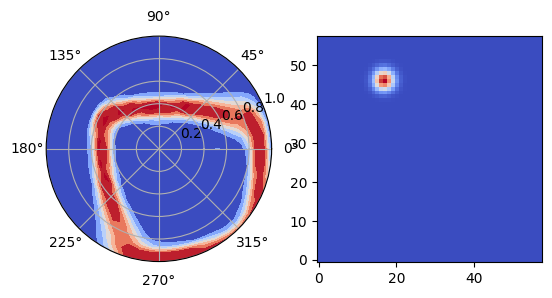

In [5]:
from matplotlib import pyplot as plt


fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, projection='polar')
theta_bvc, r_bvc = np.meshgrid(
    np.linspace(0, 2 * np.pi, 51),  # Angular dimension
    np.linspace(0, 1, 16)  # Radial dimension, adjust as necessary
)

ax.contourf(
    theta_bvc.T,
    r_bvc.T,
    np.reshape(samples[1050].bvc, (51, 16)),
    cmap='coolwarm',
    vmin=0, vmax=1,
    extend="both"
)


ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(np.reshape(samples[1050].pc, (58, 58)), origin='lower', cmap='coolwarm')

In [6]:
np.sqrt(len(samples[1050].pc))

58.0

In [86]:
def wrap_indices(i, j, rows, cols):
    # Wrap the row index
    wrapped_i = ((i % rows) + rows) % rows
    # Wrap the column index
    wrapped_j = ((j % cols) + cols) % cols
    return (wrapped_i, wrapped_j)


def create_index_matrix(m, n):
    # Calculate the center indices
    center_x, center_y = m // 2, n // 2

    # Generate a matrix for x-axis indices
    x_indices = np.arange(m).reshape(m, 1) - center_x
    # Generate a matrix for y-axis indices
    y_indices = np.arange(n).reshape(1, n) - center_y

    # Tile the indices to form matrices of shape (m, n)
    x_matrix = np.tile(x_indices, (1, n))
    y_matrix = np.tile(y_indices, (m, 1))

    return x_matrix, y_matrix



def create_ricker_matrix(m, n, a=None):
    # Create an m x n matrix
    matrix = np.zeros((m, n))

    if a is None:
        a = min(m, n) // 10

    # Calculate the center of the matrix
    center_x, center_y = m // 2, n // 2

    # Iterate over the matrix to apply the Ricker wavelet function
    for i in range(m):
        for j in range(n):
            # Calculate distances from the center
            x = i - center_x
            y = j - center_y
            # Calculate the Ricker wavelet value
            factor = (x**2 + y**2) / a**2
            matrix[i, j] = (1 - factor) * np.exp(-factor / 2)

    return matrix


def create_gaussian_matrix(m, n, sigma = None):
    # Create an m x n matrix
    matrix = np.zeros((m, n))

    if sigma is None:
        sigma = min(m, n) // 10

    # Calculate the center of the matrix
    center_x, center_y = m // 2, n // 2

    # Iterate over the matrix to apply the Gaussian function
    for i in range(m):
        for j in range(n):
            # Calculate the Gaussian value
            matrix[i, j] = np.exp(-((i - center_x) ** 2 + (j - center_y) ** 2) / (2 * sigma ** 2))

    return matrix


class AttractorIndexer:
    def __init__(self, shape):
        self.shape = shape

    def __getitem__(self, shift):
        vertical_shift, horizontal_shift = shift
        vertical_shift *= -1
        rows, cols = self.shape

        # Calculate new row indices
        row_indices = (np.arange(rows) - vertical_shift) % rows
        # Calculate new column indices
        col_indices = (np.arange(cols) - horizontal_shift) % cols

        return np.ix_(row_indices, col_indices)


class AttractorState:
    def __init__(self, kernel: np.ndarray, weights: np.ndarray, indexer: AttractorIndexer):
        self.kernel = kernel
        self.weights = weights
        self.indexer = indexer

    @property
    def shape(self):
        return self.kernel.shape

    def __getitem__(self, indices):
        i, j = wrap_indices(*indices, *self.kernel.shape)
        ratio = self.kernel[i, j]
        if len(self.weights.shape) == 3:
            return self.weights[:, *self.indexer[indices]]*ratio
        else:
            return self.weights[self.indexer[indices]]*ratio

    def __repr__(self):
        return f"AttractorState(attractor={self.kernel}, weights={self.weights})"


class Attractor:
    def __init__(
        self,
        attractor_kernel,
    ):
        self.attractor_kernel = attractor_kernel
        self.attractor_weights = attractor_kernel[create_index_matrix(*attractor_kernel.shape)]
        self.indexer = AttractorIndexer(attractor_kernel.shape)

    @property
    def shape(self):
        return self.attractor_kernel.shape

    def __call__(self, weights: np.ndarray) -> AttractorState:
        return AttractorState(self.attractor_weights, weights, self.indexer)


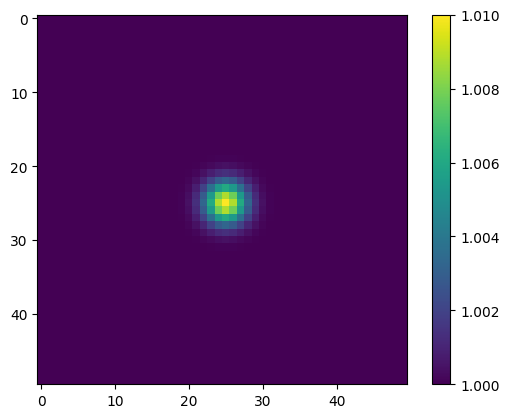

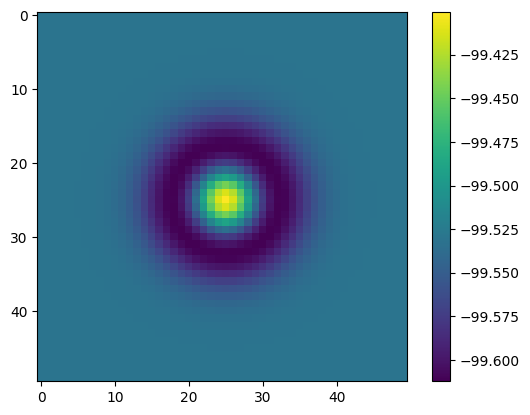

In [196]:
# all_data = np.ones((6, 6))
# all_data =  1 + .01*np.random.rand(50, 50, 50)
# all_data = np.random.rand(50, 50, 50) + create_gaussian_matrix(50, 50, 2)
all_data = 1 + .01*create_gaussian_matrix(50, 50, 2)[None, :, :]
# all_data = samples[0].bvc.reshape(51, 16)[None, :, :]

c = plt.imshow(all_data[0])
plt.colorbar(c)
plt.show()

attr = Attractor(create_ricker_matrix(*all_data.shape[-2:], 4))

# attr = Attractor(create_gaussian_matrix(*all_data.shape[-2:], 4))
state = attr(all_data.copy())
for i in range(state.shape[-2]):
    for j in range(state.shape[-1]):
        if not np.isclose(state.kernel[i, j], 0):
            all_data += state[i, j]
# all_data /= all_data.max()

c = plt.imshow(all_data[0])
plt.colorbar(c)
plt.show()

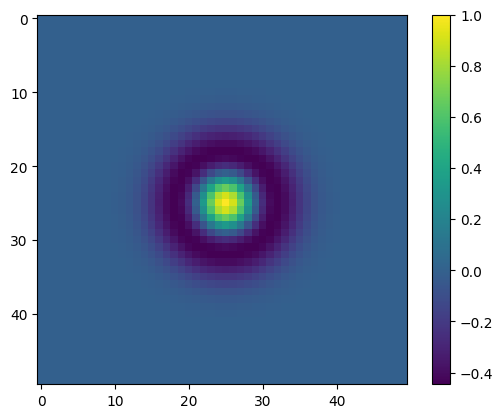

In [195]:
im = plt.imshow(attr.attractor_kernel)
plt.colorbar(im)

In [8]:
# Define a custom dataset
class GridDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        # Convert bvc and pc to tensors
        bvc_tensor = torch.FloatTensor(sample.bvc)
        pc_tensor = torch.FloatTensor(sample.pc)
        return bvc_tensor, pc_tensor

# Create the dataset
dataset = GridDataset(samples)

# Shuffle and split the dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Now you can use train_loader and test_loader for training and testing your model

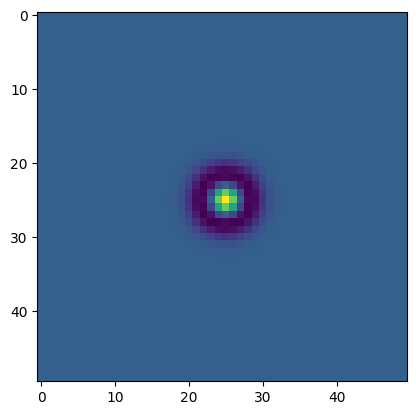

In [129]:
attr = Attractor(create_ricker_matrix(50, 50, 2))
plt.imshow(attr.attractor_kernel)

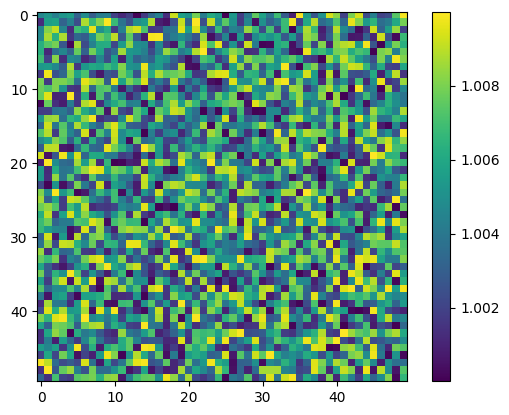

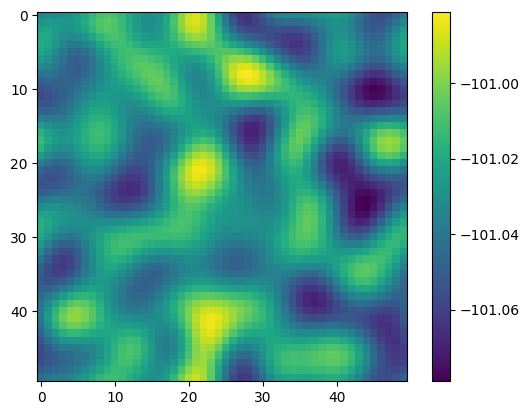

In [212]:
# all_data = np.ones((6, 6))
all_data =  1 + .01*np.random.rand(50, 50, 50)
# all_data = np.random.rand(50, 50, 50) + create_gaussian_matrix(50, 50, 2)
# all_data = samples[0].bvc.reshape(51, 16)[None, :, :]

c = plt.imshow(all_data[0])
plt.colorbar(c)
plt.show()

attr = Attractor(create_ricker_matrix(*all_data.shape[-2:], 4))

# attr = Attractor( - create_gaussian_matrix(*all_data.shape[-2:], 2))
# out = all_data.copy()
out = np.zeros_like(all_data)
state = attr(all_data.copy())
for i in range(state.shape[-2]):
    for j in range(state.shape[-1]):
        if not np.isclose(state.kernel[i, j], 0):
            # all_data += state[i, j]
            out += state[i, j]
# all_data /= all_data.max()

c = plt.imshow(out[0])
plt.colorbar(c)
plt.show()

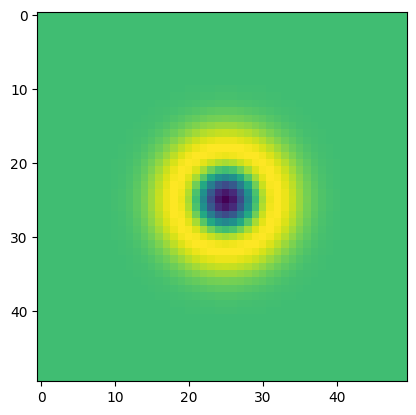

In [204]:
plt.imshow(attr.attractor_kernel)

In [11]:
import torch.nn as nn

class AttrGridNet(nn.Module):
    def __init__(self, m, n, p, activation=None):
        super().__init__()
        self.layer1 = nn.Linear(m, n)
        self.layer2 = nn.Linear(n, p)
        self.attractors = [
            Attractor(torch.tensor(create_ricker_matrix(25, 25, i+1), dtype=torch.float32))
            # Attractor(torch.tensor(create_ricker_matrix(10, 10, i+1), dtype=torch.float32))
            for i in range(7)
        ]

        # Select the activation function
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        elif isinstance(activation, nn.Module):
            self.activation = activation
        elif activation is None:
            self.activation = nn.Identity()
        else:
            raise ValueError(f'Unsupported activation function: {activation}')
        # self.bn = nn.BatchNorm1d(7*25*25)

    def forward(self, x):
        x = self.layer1(x)
        m = 25
        n = 25
        x = x.view(-1, m, n, 7)
        all_x = list()

        for i, attr in enumerate(self.attractors):
            x_current = x[:, :, :, i ].clone()
            state = attr(x_current.clone())
            for j in range(m):
                for k in range(n):
                    if not torch.isclose(state.kernel[j, k], torch.tensor(0, dtype=torch.float32)):
                        x_current += state[j, k]
                        # x_current /= x_current.max()
            # x_current = x_current.view(-1, m*n)
            all_x.append(x_current)

        x = torch.stack(all_x, -1)
        x = x.view(-1, m*n*7)
        # return x
        # x = self.bn(x)
        x = self.layer2(x)
        x = self.activation(x)
        return x

net = AttrGridNet(100, 7*25*25, 10)
# net = AttrGridNet(100, 7*10*10, 10)
x = net(torch.rand(11, 100)).detach().numpy()

In [12]:
x.shape

(11, 10)

In [13]:
im = plt.imshow(
    np.reshape(
        x[0], (25, 25, 7)
        # x[0], (10, 10, 7)
    )[:, :, 2]
)
plt.colorbar(im)

ValueError: cannot reshape array of size 10 into shape (25,25,7)

In [14]:
import torch
import torch.nn as nn
import numpy as np

class DynamicWeightedMSELoss(nn.Module):
    def __init__(self, sigma=10.0):
        """
        Initializes the dynamic weighted MSE loss.
        :param sigma: The standard deviation of the Gaussian weight distribution.
        """
        super(DynamicWeightedMSELoss, self).__init__()
        self.sigma = sigma

    def forward(self, prediction, target):
        """
        Computes the dynamic weighted MSE loss.
        :param prediction: The predicted output (flattened).
        :param target: The target output (flattened).
        """
        # Reshape prediction and target to 2D (assuming 58x58 as mentioned)
        pred = prediction.view(-1, 58, 58)
        targ = target.view(-1, 58, 58)

        # batch_size, height, width = targ.shape
        # targ_flat = targ.view(batch_size, -1)
        # _, indices = targ_flat.max(1)  # Find the index of the max value in the flattened target
        # centers_y = indices // width
        # centers_x = indices % width

        # # Create a meshgrid of coordinates (x, y) for each pixel
        # x = torch.arange(0, width, device=pred.device).repeat(height, 1)
        # y = torch.arange(0, height, device=pred.device).repeat(1, width)

        # # Compute weights for each example in the batch
        # weights = torch.zeros_like(pred)
        # for i in range(batch_size):
        #     center_x = centers_x[i].float()
        #     center_y = centers_y[i].float()
        #     dist_sq = (x - center_x)**2 + (y - center_y)**2
        #     weights[i] = torch.exp(-dist_sq / (2 * self.sigma**2))

        # # Normalize weights to have a maximum of 1
        # weights = weights / weights.view(batch_size, -1).max(1)[0].view(-1, 1, 1)

        # Compute weighted MSE
        diff = pred - targ
        # weighted_diff = diff * weights
        # loss = (weighted_diff**2).mean()
        loss = (diff**2).sum()

        return loss

# Example usage
prediction = torch.randn(10, 3364)  # Example prediction
target = torch.randn(10, 3364)  # Example target, with the peak at different positions
loss_fn = DynamicWeightedMSELoss(sigma=10)  # Initialize with a chosen sigma
loss = loss_fn(prediction, target)
print(loss)

tensor(67155.3047)


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assuming your model is already defined and instantiated
# model = AttrGridNet(816, 700, 3364)
model = AttrGridNet(816, 7*25*25, 3364)


# Define the loss function and optimizer
criterion = DynamicWeightedMSELoss()  # Assuming RMSLELoss is defined elsewhere
optimizer = optim.Adam(model.parameters())

# Specify the number of epochs and the L2 regularization strength
num_epochs = 100
l2_lambda = 0.001  # L2 regularization strength

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for inputs, targets in train_loader:
        # Move data to the appropriate device
        inputs, targets = inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Manually add L2 regularization for layer1
        # l2_penalty = None
        # for param in model.layer1.parameters():
        #     if l2_penalty is None:
        #         l2_penalty = param.norm(2)
        #     else:
        #         l2_penalty = l2_penalty + param.norm(2)
        # l2_penalty = l2_lambda * l2_penalty

        # Combine the original loss with the L2 penalty
        # loss = loss + l2_penalty

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    # Optional: Evaluate the model on the test set after each epoch
    # (Evaluation code remains unchanged)

print('Training complete')

Epoch 1/100, Loss: 12410513.9335
Epoch 2/100, Loss: 147022.9487
Epoch 3/100, Loss: 21007.8846
Epoch 4/100, Loss: 13881.9142
Epoch 5/100, Loss: 10586.9327
Epoch 6/100, Loss: 8620.8507
Epoch 7/100, Loss: 7168.4106
Epoch 8/100, Loss: 6215.4353
Epoch 9/100, Loss: 5424.7519
Epoch 10/100, Loss: 4838.4537
Epoch 11/100, Loss: 4368.8719
Epoch 12/100, Loss: 4080.0841
Epoch 13/100, Loss: 3676.9185
Epoch 14/100, Loss: 3383.5634
Epoch 15/100, Loss: 3325.7168
Epoch 16/100, Loss: 2971.3080
Epoch 17/100, Loss: 2788.2100
Epoch 18/100, Loss: 2707.1422
Epoch 19/100, Loss: 2494.1482
Epoch 20/100, Loss: 2408.9077
Epoch 21/100, Loss: 2312.0781
Epoch 22/100, Loss: 2172.7669
Epoch 23/100, Loss: 2083.4299
Epoch 24/100, Loss: 2154.5059
Epoch 25/100, Loss: 2306.1761
Epoch 26/100, Loss: 1918.0056
Epoch 27/100, Loss: 1839.6142
Epoch 28/100, Loss: 1747.0938
Epoch 29/100, Loss: 1913.4149
Epoch 30/100, Loss: 1687.0851
Epoch 31/100, Loss: 1656.5379
Epoch 32/100, Loss: 1542.3259
Epoch 33/100, Loss: 1556.3301
Epoch 34/1

KeyboardInterrupt: 

In [137]:
with torch.no_grad():
    model.eval()
    x, y = next(iter(test_loader))
    pred = model(x)


In [18]:
x.shape, pred.shape

(torch.Size([64, 816]), torch.Size([64, 3364]))

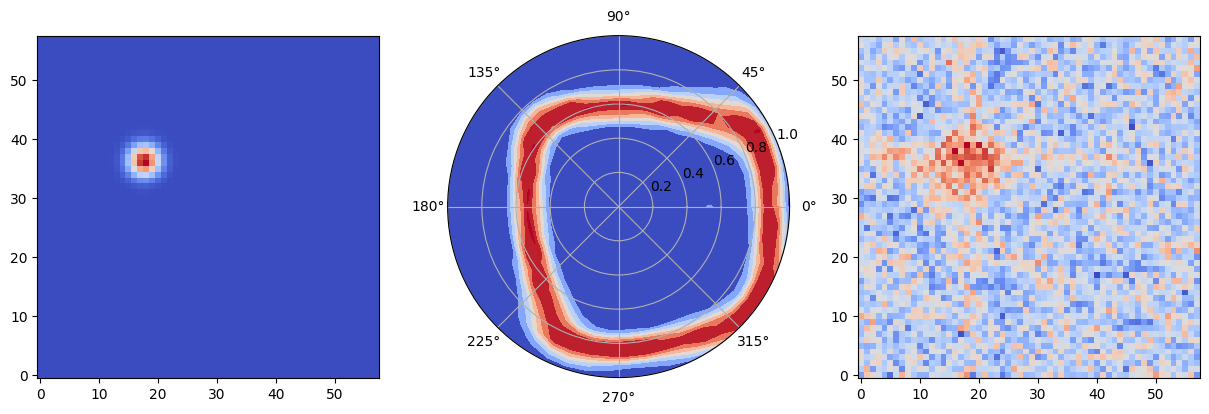

In [138]:
from matplotlib import pyplot as plt


theta_bvc, r_bvc = np.meshgrid(
    np.linspace(0, 2 * np.pi, 51),  # Angular dimension
    np.linspace(0, 1, 16)  # Radial dimension, adjust as necessary
)


# ax2 = fig.add_subplot(1, 2, 2)
# ax2.imshow(np.reshape(samples[1050].pc, (58, 58)), origin='lower', cmap='coolwarm')


fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2, projection='polar')
ax3 = fig.add_subplot(1, 3, 3)

i = 2

ax1.imshow(np.reshape(y[i], (58, 58)), origin='lower', cmap='coolwarm')

ax2.contourf(
    theta_bvc.T,
    r_bvc.T,
    np.reshape(x[i], (51, 16)),
    cmap='coolwarm',
    vmin=0, vmax=1,
    extend="both"
)

ax3.imshow(np.reshape(pred[i], (58, 58)), origin='lower', cmap='coolwarm')


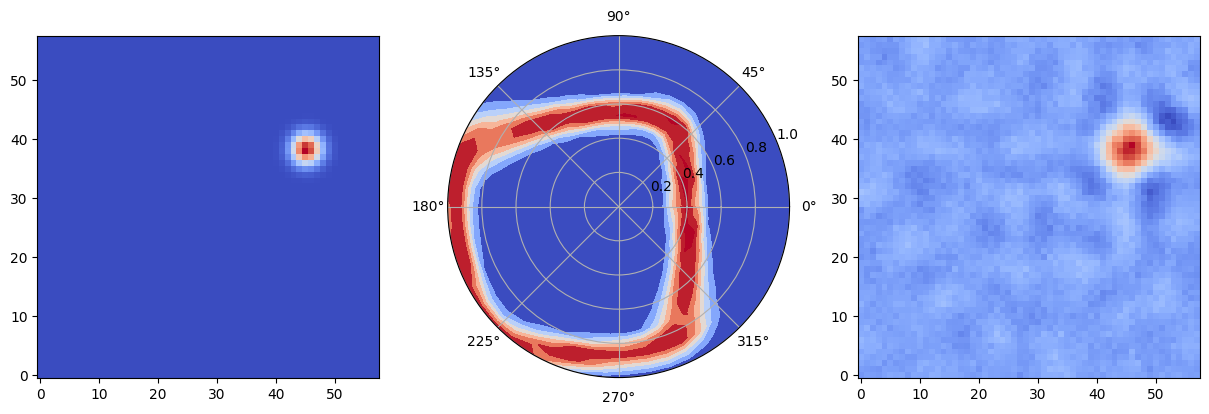

In [ ]:
from matplotlib import pyplot as plt


theta_bvc, r_bvc = np.meshgrid(
    np.linspace(0, 2 * np.pi, 51),  # Angular dimension
    np.linspace(0, 1, 16)  # Radial dimension, adjust as necessary
)


# ax2 = fig.add_subplot(1, 2, 2)
# ax2.imshow(np.reshape(samples[1050].pc, (58, 58)), origin='lower', cmap='coolwarm')


fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2, projection='polar')
ax3 = fig.add_subplot(1, 3, 3)

i = 2

ax1.imshow(np.reshape(y[i], (58, 58)), origin='lower', cmap='coolwarm')

ax2.contourf(
    theta_bvc.T,
    r_bvc.T,
    np.reshape(x[i], (51, 16)),
    cmap='coolwarm',
    vmin=0, vmax=1,
    extend="both"
)

ax3.imshow(np.reshape(pred[i], (58, 58)), origin='lower', cmap='coolwarm')


In [21]:
all_bvcs = list()
for sample in dataset:
    all_bvcs.append(sample[0])

In [22]:
torch.stack(all_bvcs).shape

torch.Size([3481, 816])

In [ ]:
m, n  = 25, 25
inputs = list()
outputs = list()

with torch.no_grad():
    model.eval()
    # x, y = next(iter(test_loader))
    # bvc2gc = model.layer1(torch.stack(all_bvcs)).detach().numpy()
    x = model.layer1(torch.stack(all_bvcs))
    x = x.view(-1, m, n, 7)
    inputs.append(x.clone().detach().numpy())
    all_x = list()
    layers = [x[:, :, :, i ].clone() for i in range(len(model.attractors))]
    for layer, attr in zip(layers, model.attractors):
        x_current = x[:, :, :, i ].clone()
        state = attr(layer.clone())
        for j in range(m):
            for k in range(n):
                if not torch.isclose(state.kernel[j, k], torch.tensor(0, dtype=torch.float32)):
                    layer += state[j, k]
        # x_current = x_current.view(-1, 100)
        all_x.append(layer)

    x = torch.stack(all_x, -1)
    outputs.append(x.clone().detach().numpy())
    x = x.view(-1, 7*m*n)
    # x = x.view(-1, 10, 10, 7)
    # bvc2gc = model.bn(x)
    # print(bvc2gc.shape)

In [167]:
m, n  = 25, 25
inputs = list()
outputs = list()

with torch.no_grad():
    model.eval()
    # x, y = next(iter(test_loader))
    # bvc2gc = model.layer1(torch.stack(all_bvcs)).detach().numpy()
    x = model.layer1(torch.stack(all_bvcs))
    x = x.view(-1, m, n, 7)
    inputs.append(x.clone().detach().numpy())
    all_x = list()
    for i, attr in enumerate(model.attractors):
        x_current = x[:, :, :, i ].clone()
        state = attr(x_current.clone())
        for j in range(m):
            for k in range(n):
                if not torch.isclose(state.kernel[j, k], torch.tensor(0, dtype=torch.float32)):
                    x_current += state[j, k]
        # x_current = x_current.view(-1, 100)
        all_x.append(x_current)

    x = torch.stack(all_x, -1)
    outputs.append(x.clone().detach().numpy())
    x = x.view(-1, 7*m*n)
    # x = x.view(-1, 10, 10, 7)
    # bvc2gc = model.bn(x)
    # print(bvc2gc.shape)

In [141]:
inputs[0].shape

(3481, 25, 25, 7)

In [ ]:

for i in [1, 100, 200, 300, 400, 500]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.imshow(inputs[0][i, :, :, 2])
    ax2.imshow(outputs[0][i, :, :, 2])
    plt.show()

In [25]:
x.shape

torch.Size([3481, 4375])

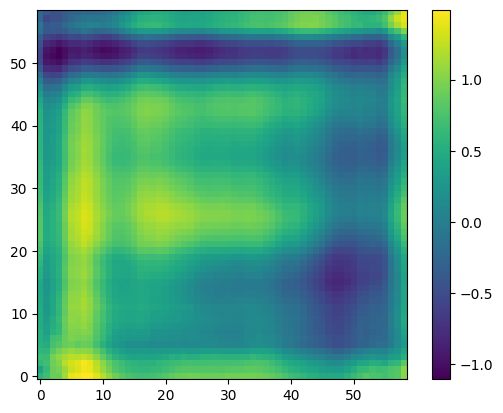

In [165]:

im = plt.imshow(np.reshape(x[:, 0], (59, 59)), origin='lower',)
plt.colorbar(im)
plt.show()

In [ ]:

im = plt.imshow(np.reshape(x[:, 0, 0, 6], (59, 59)), origin='lower',)
plt.colorbar(im)
plt.show()

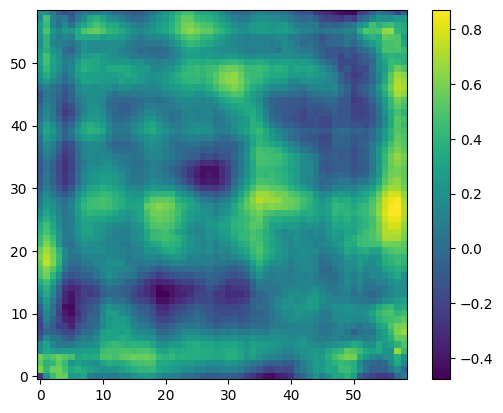

In [ ]:

im = plt.imshow(np.reshape(x[:, 0, 0, 6], (59, 59)), origin='lower',)
plt.colorbar(im)
plt.show()

In [ ]:
for i in range(700):
    im = plt.imshow(np.reshape(x[:, i], (59, 59)), origin='lower',)
    plt.colorbar(im)
    plt.show()

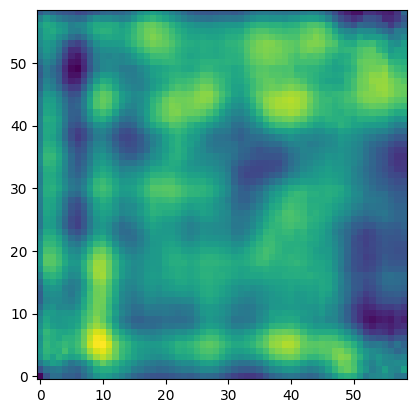

In [ ]:
plt.imshow(np.reshape(x[:, 0], (59, 59)), origin='lower')